# 作者:皇甫承佑 2021/10/01

In [7]:
import warnings
import mlflow
from tensorflow.keras.models import load_model
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
def prepare_data(data, to_3_channels=True, to_clahe=False):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array in shape(48,48,3) and pixel range(0,256) """
    clahe = cv2.createCLAHE(clipLimit=2)
    channels = 3 if to_3_channels == True else 1

    image_array = np.zeros(shape=(len(data), 48, 48, channels))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))  # 灰階圖的channel數為1

        #  CLAHE (Contrast Limited Adaptive Histogram Equalization)
        if to_clahe == True:
            image = image[:, :, 0].astype("uint8")
            image = clahe.apply(image)
            image = np.reshape(image, (48, 48, 1))

        # Convert to 3 channels
        if to_3_channels == True:
            image = np.stack(
                [image[:, :, 0], image[:, :, 0], image[:, :, 0]], axis=-1)
        image_processed = preprocess_input(image)
        image_array[i] = image_processed

    return image_array, image_label


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def evaluate_model(model, X_val, y_val):
    # 混淆矩陣
    y_prob_val = model.predict(X_val)
    y_pred_val = np.argmax(y_prob_val, axis=-1)
    plot_confusion_matrix(confusion_matrix(y_val, y_pred_val),
                          classes=list(emotions.values()))
    print(classification_report(y_val, y_pred_val, target_names=list(emotions.values()), digits=4))

# 全域變數與設定

In [8]:
warnings.filterwarnings('ignore')

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

mlflow.set_tracking_uri("http://192.168.1.3:5000")# 指定tracking uri


# 從server載入model (EFFB0)

In [9]:
run_id = "09d1cafc7a584f8782b1f2aeb1882442" #run_name = EFNB0_ADAM_free1000_POLY_aug
logged_model = "runs:/"+run_id+"/model"
effB0 = mlflow.keras.load_model(logged_model)

# 從local載入model (EFFB7)


In [10]:

# run_name = FINAL_EFNB7_ADAM_FREE1000_balanceCW_POLY_AUG
best_model_path = "./checkpoints/EFNB7_ADAM_FREE1000_balanceCW_POLY_AUG/ADAM_FREE1000_balanceCW_POLY_AUG_epoch92_valacc0.6684.h5"
effB7 = load_model(best_model_path)

# 讀取資料

In [11]:
#  資料讀取
df_raw = pd.read_csv("./data/FER2013/fer2013.csv")
#  資料前處理
X_val, y_val = prepare_data(df_raw[df_raw['Usage'] == 'PublicTest'])
X_test, y_test = prepare_data(df_raw[df_raw['Usage'] == 'PrivateTest'])

# 評價模型

## EfficientNetB0

--------Public Test--------
              precision    recall  f1-score   support

       Angry     0.5541    0.5268    0.5401       467
     Disgust     0.6600    0.5893    0.6226        56
        Fear     0.5629    0.4778    0.5169       496
       Happy     0.8160    0.8425    0.8290       895
         Sad     0.5328    0.5590    0.5456       653
    Surprise     0.7752    0.8145    0.7944       415
     Neutral     0.5723    0.5931    0.5825       607

    accuracy                         0.6500      3589
   macro avg     0.6391    0.6290    0.6330      3589
weighted avg     0.6471    0.6500    0.6478      3589



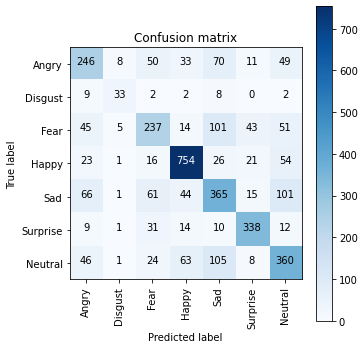

In [12]:
# 驗證集
print("--------Public Test--------")
evaluate_model(effB0, X_val, y_val)

--------Private Test--------
              precision    recall  f1-score   support

       Angry     0.5786    0.5397    0.5585       491
     Disgust     0.7407    0.7273    0.7339        55
        Fear     0.5428    0.4924    0.5164       528
       Happy     0.8056    0.8441    0.8244       879
         Sad     0.4914    0.5286    0.5093       594
    Surprise     0.7512    0.7620    0.7566       416
     Neutral     0.6120    0.6022    0.6071       626

    accuracy                         0.6450      3589
   macro avg     0.6461    0.6423    0.6437      3589
weighted avg     0.6428    0.6450    0.6434      3589



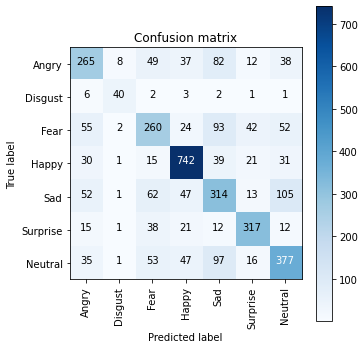

In [19]:
# 測試集
print("--------Private Test--------")
evaluate_model(effB0, X_test, y_test)

## EfficientNetB7

--------Public Test--------
              precision    recall  f1-score   support

       Angry     0.6100    0.5760    0.5925       467
     Disgust     0.8537    0.6250    0.7216        56
        Fear     0.6218    0.4476    0.5205       496
       Happy     0.8232    0.8480    0.8354       895
         Sad     0.5289    0.6018    0.5630       653
    Surprise     0.7753    0.8313    0.8023       415
     Neutral     0.5875    0.6194    0.6030       607

    accuracy                         0.6684      3589
   macro avg     0.6858    0.6499    0.6626      3589
weighted avg     0.6692    0.6684    0.6658      3589



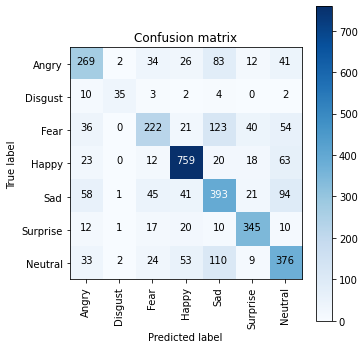

In [17]:
# 驗證集
print("--------Public Test--------")
evaluate_model(effB7, X_val, y_val)

--------Private Test--------
              precision    recall  f1-score   support

       Angry     0.5714    0.5540    0.5626       491
     Disgust     0.7551    0.6727    0.7115        55
        Fear     0.6054    0.4678    0.5278       528
       Happy     0.8534    0.8544    0.8539       879
         Sad     0.5029    0.5791    0.5383       594
    Surprise     0.7747    0.8101    0.7920       416
     Neutral     0.6195    0.6502    0.6345       626

    accuracy                         0.6673      3589
   macro avg     0.6689    0.6555    0.6601      3589
weighted avg     0.6689    0.6673    0.6662      3589



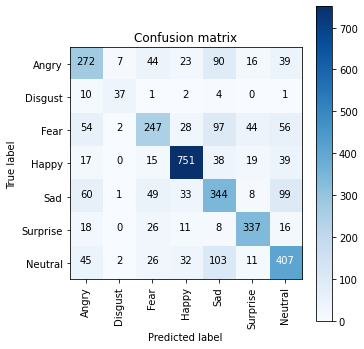

In [18]:
# 測試集
print("--------Private Test--------")
evaluate_model(effB7, X_test, y_test)

# 轉存成tflite

In [22]:
import tensorflow as tf
final_model_path = "./checkpoints/EFNB0_ADAM_free1000_POLY_aug/ADAM_free1000_POLY_aug_epoch99_valacc0.6506.h5"
final_model = load_model(final_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()
# Save the model.
with open("./models/effB0_fer" + ".tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp6e0uigo3\assets


# 轉存成metadata model

In [23]:
# %% 生成 model metadata
from tflite_support.metadata_writers import writer_utils
from tflite_support.metadata_writers import image_classifier

ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "./models/effB0_fer.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "./data/FER2013_labels.txt"
_SAVE_TO_PATH = "./models/effB0_fer_meta.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 0
_INPUT_NORM_STD = 1

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  0.0
                ],
                "std": [
                  1.0
                ]
              }
            }
          ],
          "stats": {
            "max": [
              255.0
            ],
            "min": [
              0.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probabil